
This notebook consists of two tasks. 

You should read and run it and  fill all the parts containing the **TODO** words.

# Task 1: What influences weight loss [40 points]

In this section, you will investigate the factors influencing weight. In particular, we are interested whether amount of smoking now affects body weight after 10 years. The null hypothesis is that amount smoking does not affect it. 

We will explore the data from US [National Health and Nutrition Examination Survey Data I Epidemiologic Follow-up Study](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/). It includes data from persons 25-74 years of age who completed a medical examination in 1971. Follow-up examinations were carried out several years later to investigate the relationships between clinical, nutritional, and behavioral factors.

We use a subset of data preprocessed for [Hernán MA, Robins JM (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/). It includes only people who were smoking in 1971. A codebook describing the meaning of the variables is available as [an Excel table](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2012/10/NHEFS_Codebook.xls).

To test the null hypothesis about effect of smoking intensity on weight loss, you should train a regression model predicting weight in year 1982 (`wt82`) using number of cigarretes smoked per day in 1971 (`smokeintensity`) and control factors from year 1971 that might affect weight later, such as sex (`sex`), age `age`, and, obviously,  weight in 1971 (`wt71`), and test the significance of the coefficients for the variables of interest. 

You may use any other variables, but only if they are not "from the future" (observed later than 1971). 

If you intent to do feature engineering, such as nonlinear features or interactions, you may want to read [the statsmodels documentation about their formula language](https://www.statsmodels.org/stable/example_formulas.html).

In [15]:
!wget https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2017/01/nhefs_excel.zip
!unzip nhefs_excel.zip 

--2020-11-23 19:27:25--  https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2017/01/nhefs_excel.zip
Resolving cdn1.sph.harvard.edu (cdn1.sph.harvard.edu)... 13.225.150.69, 13.225.150.122, 13.225.150.98, ...
Connecting to cdn1.sph.harvard.edu (cdn1.sph.harvard.edu)|13.225.150.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158798 (155K) [application/zip]
Saving to: ‘nhefs_excel.zip.1’

nhefs_excel.zip.1   100%[===================>] 155.08K   495KB/s    in 0.3s    

2020-11-23 19:27:26 (495 KB/s) - ‘nhefs_excel.zip.1’ saved [158798/158798]

Archive:  nhefs_excel.zip
replace NHEFS.xls? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NHEFS.xls               


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None

In [17]:
data = pd.read_excel('NHEFS.xls')
print(data.shape)
data.sample(10)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
(1629, 64)


,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,race,income,marital,school,education,ht,wt71,wt82,wt82_71,birthplace,smokeintensity,smkintensity82_71,smokeyrs,asthma,bronch,tb,hf,hbp,pepticulcer,colitis,hepatitis,chroniccough,hayfever,diabetes,polio,tumor,nervousbreak,alcoholpy,alcoholfreq,alcoholtype,alcoholhowmuch,pica,headache,otherpain,weakheart,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
346,9051,0,0,NaN,NaN,NaN,128.0,66.0,1,26,1,18.0,2,12,3,166.78125,73.48,74.389149,0.909149,18.0,20,0,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,1,1.0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2.0,209.0,0.0,1.706299,1.665283,0.734985,0.406982,0.040894,0.327942
121,2955,0,0,NaN,NaN,NaN,100.0,68.0,1,37,0,19.0,2,12,3,164.00000,50.24,54.884677,4.644677,18.0,30,10,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,3,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,4.0,215.0,0.0,1.706299,1.665283,0.734985,0.406982,0.040894,0.327942
982,21392,0,0,NaN,NaN,NaN,87.0,63.0,1,29,0,21.0,2,12,3,159.09375,54.66,60.327785,5.667785,25.0,10,0,11,0,0,0,0,2,0,0,0,1,0,2,0,0,0,1,3,3,3.0,2,0,0,0,0,0,0,2,2,1,0,1,1,1,NaN,198.0,1.0,2.414551,1.951172,1.259766,0.637939,0.463562,0.621948
566,14096,1,0,NaN,NaN,NaN,102.0,64.0,1,44,0,19.0,2,2,1,171.09375,58.29,60.781378,2.491378,45.0,20,-20,27,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,3,4,NaN,0,1,1,0,0,1,0,1,0,0,0,1,2,1,2.0,245.0,0.0,1.790283,1.592773,0.734985,0.329956,0.197479,0.404968
557,14068,0,1,92.0,5.0,17.0,135.0,95.0,0,38,0,13.0,2,6,1,179.37500,77.22,78.925072,1.705072,47.0,40,20,22,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,4,NaN,0,1,1,0,0,1,0,0,1,0,1,1,2,2,NaN,270.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1594,24847,0,0,NaN,NaN,NaN,136.0,90.0,1,42,0,21.0,4,17,5,169.28125,56.13,64.410117,8.280117,47.0,4,-1,22,0,0,1,0,2,0,0,0,0,0,2,0,0,0,1,0,2,2.0,2,1,1,0,0,1,0,2,2,0,0,1,0,1,1.0,202.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
493,12667,1,1,88.0,2.0,26.0,120.0,54.0,0,66,0,14.0,2,3,1,169.00000,68.38,72.121187,3.741187,47.0,40,-40,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1.0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,NaN,191.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
943,21233,0,0,NaN,NaN,NaN,107.0,71.0,0,37,0,18.0,2,10,2,174.09375,77.11,88.450512,11.340512,19.0,22,-12,17,0,0,0,0,2,0,0,0,0,0,2,0,0,0,1,3,4,NaN,2,1,0,0,0,0,0,2,2,0,0,0,2,2,NaN,233.0,0.0,2.199707,1.847900,1.102295,0.571899,0.351746,0.530396
1584,24820,0,0,NaN,NaN,NaN,110.0,80.0,1,33,0,20.0,2,12,3,159.37500,79.04,81.646627,2.606627,36.0,35,-5,17,0,0,0,0,2,0,0,0,0,0,2,0,0,0,1,2,3,4.0,2,1,1,0,0,0,0,2,2,0,0,0,1,0,3.0,177.0,0.0,2.241699,1.828125,1.049805,0.505981,0.413574,0.543945
913,21069,0,0,NaN,NaN,NaN,102.0,74.0,0,43,0,19.0,2,12,3,175.37500,57.61,56.245454,-1.364546,39.0,60,-40,23,0,0,0,0,2,0,0,0,1,0,2,0,0,0,1,0,1,6.0,2,0,0,0,0,0,1,2,2,0,0,0,2,2,NaN,194.0,0.0,2.015625,1.814941,0.944946,0.483948,0.200989,0.460999


In [ ]:
non_missing = data[data.wt82.notnull()]

<b>TODO: Visualize and summarize the joint distribution of weight in 1982, weight in 1971, and smoking intensity in 1971. Comment on it. </b>

<function matplotlib.pyplot.show>

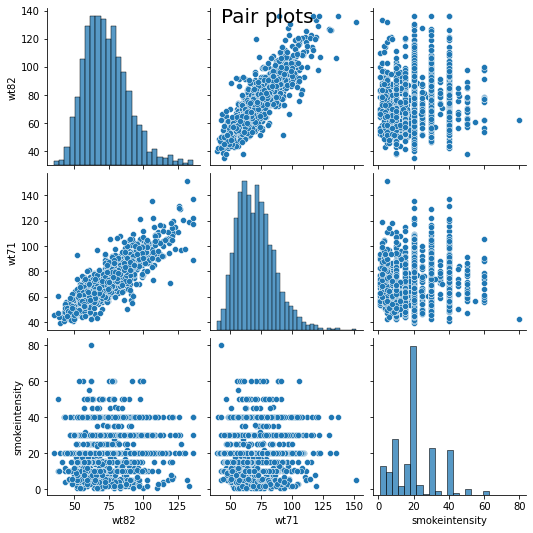

In [18]:
# TODO: your code here

# Continue on next ccode cell
variants = non_missing[['wt82','wt71','smokeintensity']]

sns.pairplot(variants)
plt.suptitle("Pair plots", size = 20)
plt.show

Correlation matrix:
                    wt82      wt71  smokeintensity
wt82            1.000000  0.875975        0.109278
wt71            0.875975  1.000000        0.100218
smokeintensity  0.109278  0.100218        1.000000


<function matplotlib.pyplot.show>

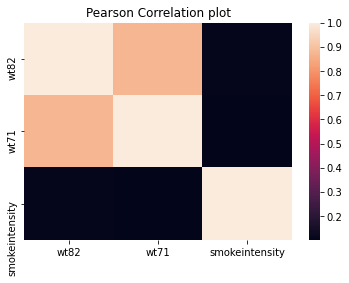

In [19]:
cor_matrix = variants.corr(method='pearson')
print("Correlation matrix:")
print(cor_matrix)

sns.heatmap(cor_matrix)
plt.title("Pearson Correlation plot")
plt.show

Spearman Correlation matrix:
                    wt82      wt71  smokeintensity
wt82            1.000000  0.873265        0.128101
wt71            0.873265  1.000000        0.112369
smokeintensity  0.128101  0.112369        1.000000


<function matplotlib.pyplot.show>

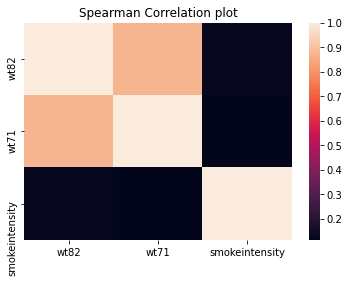

In [21]:
cor_matrix_s = variants.corr(method='spearman')
print("Spearman Correlation matrix:")
print(cor_matrix_s)

sns.heatmap(cor_matrix_s)
plt.title("Spearman Correlation plot")
plt.show

From the visualizations we notice a linear positive connection between 1971 and 1982 weights, the correlation is close to 0.9.

However it seems that there is no connnection between smoke intensity and weights (both 1971 and 1982 data). The correlation is very close to 0.1.

We will try to use somokeintensity squared value for finding a connction:

Correlation matrix:
                    wt82      wt71  smokeintensity  square_smoke
wt82            1.000000  0.875975        0.109278      0.098787
wt71            0.875975  1.000000        0.100218      0.094059
smokeintensity  0.109278  0.100218        1.000000      0.945871
square_smoke    0.098787  0.094059        0.945871      1.000000


<function matplotlib.pyplot.show>

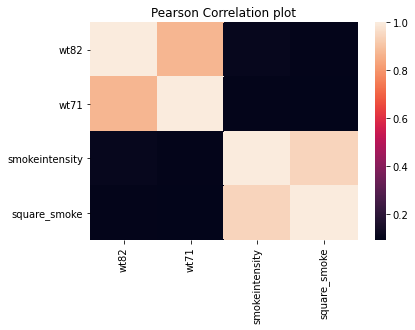

In [22]:
variants['square_smoke'] = np.power(variants.smokeintensity,2)

cor_matrix = variants.corr(method='pearson')
print("Correlation matrix:")
print(cor_matrix)

sns.heatmap(cor_matrix)
plt.title("Pearson Correlation plot")
plt.show

We didn't find a correlation.

We will try to split smokeintensity to categories and check if there is a difference between 81 weights over different categories:

       min  max  count
smoke                 
0        1   19    561
1       20   36    793
2       40   55    198
3       60   80     14


Text(0.5, 0.98, 'Boxplot of 82 weight by smoke intensity')

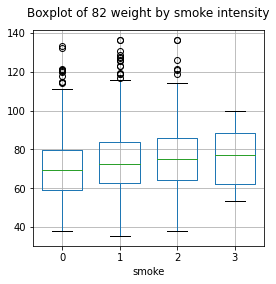

In [23]:
non_missing['smoke'] = non_missing['smokeintensity'] // 20
non_missing.loc[non_missing.smoke==4, 'smoke'] = 3

print(non_missing.smokeintensity.groupby([non_missing.smoke]).agg(['min', 'max', 'count']))
non_missing.boxplot(column='wt82', by='smoke', figsize=(4,4), widths=0.7)
plt.title(None)
plt.suptitle('Boxplot of 82 weight by smoke intensity')

The boxplot might show some relation - the median of the weight increases with the number of cigarettes per day (group 4 contained only 1 sample so we included it in group 3). However the variance and the many outliers imply that the connection is not so strait-forward, and also we were unable to spot it on the scatter chart.

<b>TODO: improve the model below by including more and better factors in it</b>

### Improving the model - step 1

In [24]:
model0=smf.ols(data=non_missing, formula='wt82~stats.zscore(wt71)+C(colitis)+stats.zscore(ht)+stats.zscore(age)+C(diabetes)+C(active)*C(smoke)').fit()
print('R2 for model: '+ str(model0.rsquared))  
mse0= np.sum((model0.predict(non_missing)-non_missing['wt82'])**2)
rmse0 = np.sqrt(mse0/ non_missing['wt82'].count())
print('RMSE for extended model: '+str(rmse0))



R2 for model: 0.7878842746808744
RMSE for extended model: 7.439377504005826


We chose these factors by commiting a series of F-tests which shown that adding these factors improving the model relative to the model without them. This procedure will be demonstrated in step 2 and step 3 below and the interpetation will follow.

###Improving the model - step 2
Adding some alcohol

In [25]:
model1 = smf.ols(data=non_missing, formula='wt82~stats.zscore(wt71)+C(colitis)+stats.zscore(ht)+stats.zscore(age)+C(diabetes)+C(active)*C(smoke)+ alcoholhowmuch').fit()#age*C(income) 

model2=smf.ols(data=non_missing, formula='wt82~stats.zscore(wt71)+C(colitis)+stats.zscore(ht)+stats.zscore(age)+C(diabetes)+C(active)*C(smoke)').fit() # without alcoholhowmuch
delta=model1.compare_f_test(model2)

print('R2 for extended model: '+ str(model1.rsquared) +'   VS.   R2 for the smaller model: ' + str(model2.rsquared))
print('p value of the F test for comparison of models: '+ str(delta[1]))
mse1= np.sum((model1.predict(non_missing)-non_missing['wt82'])**2)
rmse1 = np.sqrt(mse1/ non_missing['wt82'].count())
mse2= np.sum((model2.predict(non_missing)-non_missing['wt82'])**2)
rmse2 = np.sqrt(mse2/ non_missing['wt82'].count())
print('RMSE for extended model: '+str(rmse1) +  ' VS. RMSE for smaller model: '+ str(rmse2))

print("p value of the alcholohhowmuch coefficient :" + str(model1.pvalues['alcoholhowmuch']))

R2 for extended model: 0.7980805859411111   VS.   R2 for the smaller model: 0.7878842746808744
p value of the F test for comparison of models: 0.0058663207335278265
RMSE for extended model: 6.234257566884043 VS. RMSE for smaller model: 7.439377504005826
p value of the alcholohhowmuch coefficient :0.2483174742070793


Adding 'alcoholhowmuch' seems to improve the model as implied by higher R squared and lower RMSE. It is also shown by the significant F-Test result.
Nevertheless, p value of the coefficient is not signficant for some reason - it is hard to interpret

### Improving the model (?) - step 3 and summary

In [26]:
model1 = smf.ols(data=non_missing, formula='wt82~stats.zscore(wt71)+C(colitis)+stats.zscore(ht)+stats.zscore(age)+C(diabetes)+C(active)*C(smoke)+ alcoholhowmuch+stats.zscore(age)*C(income)').fit()# 

model2=smf.ols(data=non_missing, formula='wt82~stats.zscore(wt71)+C(colitis)+stats.zscore(ht)+stats.zscore(age)+C(diabetes)+C(active)*C(smoke)+alcoholhowmuch').fit() # without age*income
delta=model1.compare_f_test(model2)
print('R2 for extended model: '+ str(model1.rsquared) +'   VS.   R2 for the smaller model: ' + str(model2.rsquared))
print('p value of the F test for comparison of models: '+ str(delta[1]))
mse1= np.sum((model1.predict(non_missing)-non_missing['wt82'])**2)
rmse1 = np.sqrt(mse1/ non_missing['wt82'].count())
mse2= np.sum((model2.predict(non_missing)-non_missing['wt82'])**2)
rmse2 = np.sqrt(mse2/ non_missing['wt82'].count())
print('RMSE for extended model: '+str(rmse1) +  ' VS. RMSE for smaller model: '+ str(rmse2))




R2 for extended model: 0.8045496531167394   VS.   R2 for the smaller model: 0.7980805859411111
p value of the F test for comparison of models: 0.07150879073168878
RMSE for extended model: 5.992664799675646 VS. RMSE for smaller model: 6.234257566884043


Here we see that adding age*income adds to the R squared value and reduces RMSE. We can also see below that one levels of this factor has significant p value. However, surprisingly, F-Test shows no significant added value for adding this variable.  

In [28]:
p_vals = model1.pvalues
 
sig_p = p_vals[p_vals<0.05] 
coef = model1.params[sig_p.index] 
print("List of significant coefficients: ")
print(coef)

List of significant coefficients: 
Intercept                              73.811654
C(colitis)[T.1]                        -4.105485
C(diabetes)[T.1]                       -7.795922
C(active)[T.2]                         -3.352520
C(active)[T.2]:C(smoke)[T.1]            5.169221
C(active)[T.2]:C(smoke)[T.2]            5.324203
stats.zscore(wt71)                     14.381198
stats.zscore(ht)                        0.623101
stats.zscore(age)                      -3.331453
stats.zscore(age):C(income)[T.22.0]     3.282007
dtype: float64


### Interpretation
Above listed the factors that proved to be related to weight in 1982 according to their significant p value. 

The factors that influence weight and thier influence according to their coefficients:


*   The weight in 1971 - the higher the weight in 71' the higher in 82
*   Age - it seems that we get thinner as we get older. Note that this effect is reversed when it comes to very rich people - they gain more weight as they become older (in comparison to poor people) as seen by the interation of Age and the last level of income.
*   Height - Taller people in 71' weigh more in 82'
*   Colitis & Diabetes -  Having either of them in 71' means less weight in 82'

*   Day life Activity - Strangely we found that being inactive in daily life   associated with lower weight in 82' in comparison to being very active (Long live television:-)....maybe busy people eat junk food?). Note that it makes more sense in interaction with smoking - the combination of being non-active and smoke one or 2 packets a day raises the chance of being fatter. 


*   Alcohol consumption - The coefficient is not significant but as we have seen before (by the F test etc.) it seems to be a valid parmeter that adds to the model explantory power. Still it is hard to interpret the influence the amount of drinking in 71' on weight in 82'. It might be a suppressor variable which although it has no correlation with the dependent variable but it may be related somehow to another factor and by including it we increases the predictive power of that factor.











 


Strength of influence:

We scaled the numeric variables hence their coefficients are comperable and reflect the relative strenght of influence. We see that weight in 71' has the largest influence - much more than age which comes after. Height has somewhat very low impact but it may also be that as weight and height are highly correlated in the first place they explain the same variance so the impact of height is included already in the impact of weight.

 



# Task 2: Credit scoring and comparing models [60 points]

In this part, you should train a logistic regression to predict probability of not returning a loan by a bank client. 

This problem be focused not on explaining *why* some clients do not return the loan, but only on predicting *whether* they will return it (or, rather, with what probability they don't return). Therefore, we don't *have* to perform statistical tests for the model coefficients. However, these test might still be useful for finding the variables that are really useful for predicting the outcome. 

To validate the quality of prediction on the new data, we will split the data into the train and test parts. 

In [ ]:
credit_data = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/credit.csv')
print(credit_data.shape)
y = credit_data['default'] - 1  # get 1 for not returning loan, 0 for returning it
print(y.mean())
predictors = credit_data.drop('default', axis=1)
predictors.sample(5)#.T

(1000, 21)
0.3


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,dependents,telephone,foreign_worker,job
871,> 200 DM,6,critical,car (new),1343,< 100 DM,> 7 yrs,1,single male,none,4,real estate,46,none,own,2,2,none,no,skilled employee
236,1 - 200 DM,6,repaid,car (new),14555,unknown,unemployed,1,single male,none,2,building society savings,23,none,own,1,1,yes,yes,unemployed non-resident
893,1 - 200 DM,36,critical,car (used),5800,< 100 DM,1 - 4 yrs,3,single male,none,4,other,34,none,own,2,1,yes,yes,skilled employee
297,unknown,10,repaid,car (new),1287,unknown,> 7 yrs,4,single male,co-applicant,2,building society savings,45,none,own,1,1,none,no,unskilled resident
6,unknown,24,repaid,furniture,2835,501 - 1000 DM,> 7 yrs,3,single male,none,4,building society savings,53,none,own,1,1,none,yes,skilled employee


Some of the variables are categorical. To make all the data numerical, one may perform one-hot encoding of the categorical columns. 

In [ ]:
X = pd.get_dummies(predictors, drop_first=False)
X.sample(3)#.T.head(21)

,months_loan_duration,amount,installment_rate,residence_history,age,existing_credits,dependents,checking_balance_1 - 200 DM,checking_balance_< 0 DM,checking_balance_> 200 DM,checking_balance_unknown,credit_history_critical,credit_history_delayed,credit_history_fully repaid,credit_history_fully repaid this bank,credit_history_repaid,purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture,purpose_others,purpose_radio/tv,purpose_repairs,purpose_retraining,savings_balance_101 - 500 DM,savings_balance_501 - 1000 DM,savings_balance_< 100 DM,savings_balance_> 1000 DM,savings_balance_unknown,employment_length_0 - 1 yrs,employment_length_1 - 4 yrs,employment_length_4 - 7 yrs,employment_length_> 7 yrs,employment_length_unemployed,personal_status_divorced male,personal_status_female,personal_status_married male,personal_status_single male,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_building society savings,property_other,property_real estate,property_unknown/none,installment_plan_bank,installment_plan_none,installment_plan_stores,housing_for free,housing_own,housing_rent,telephone_none,telephone_yes,foreign_worker_no,foreign_worker_yes,job_mangement self-employed,job_skilled employee,job_unemployed non-resident,job_unskilled resident
212,27,5293,2,4,50,2,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
125,12,2121,4,2,30,2,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
762,12,2214,4,3,24,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Here is the logistic regression model trained on all the variables. However, only for the numerical variables here the test for coefficient significance makes sense. 

**TODO: interpret the signs and significance of the numerical factors (the first 7, from `months_loan_duration` to `dependents`).**

**Answer:**

months_loan_duration: the coefficiant is significantly not zoro and positive, hence the higher the month loan duration the higher the probability of not returning the loan.

amount: also, the coefficiant is significantly not zoro and positive, hence the higher the amount the higher the probability of not returning the loan.

installment_rate: also, the coefficiant is significantly not zoro and positive, hence the higher the installmant rate the higher the probability of not returning the loan.

residence_history: the coefficient is not significantly different from zero.

age: the coefficient is not significantly different from zero.

existing_credits: the coefficient is not significantly different from zero.

dependents: the coefficient is not significantly different from zero.



In [ ]:
import statsmodels.api as sm
full_model = sm.Logit(y_train, X_train).fit()
full_model.summary()

Optimization terminated successfully.
         Current function value: 0.438871
         Iterations 11


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  800
Model:                          Logit   Df Residuals:                      751
Method:                           MLE   Df Model:                           48
Date:                Mon, 23 Nov 2020   Pseudo R-squ.:                  0.2828
Time:                        11:38:24   Log-Likelihood:                -351.10
converged:                       True   LL-Null:                       -489.54
Covariance Type:            nonrobust   LLR p-value:                 6.186e-34
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
months_loan_duration                      0.0235      0.011      2.134      0.033       0.002       0.045
amount                                    0.0002   5.21e-05      3.310      0.001    7.04e-05       0.000
installment_rate                          0.4333      0.101      4.298      0.000       0.236       0.631
residence_history                         0.0825      0.099      0.834      0.404      -0.111       0.276
age                                      -0.0176      0.010     -1.698      0.089      -0.038       0.003
existing_credits                          0.2789      0.223      1.248      0.212      -0.159       0.717
dependents                                0.3969      0.288      1.377      0.168      -0.168       0.962
checking_balance_1 - 200 DM               1.9475        nan        nan        nan         nan         nan
checking_balance_< 0 DM                   2.4459        nan        nan        nan         nan         nan
checking_balance_> 200 DM                 1.6381        nan        nan        nan         nan         nan
checking_balance_unknown                  0.7431        nan        nan        nan         nan         nan
credit_history_critical                  -1.0341   9.68e+06  -1.07e-07      1.000    -1.9e+07     1.9e+07
credit_history_delayed                   -0.3071   9.63e+06  -3.19e-08      1.000   -1.89e+07    1.89e+07
credit_history_fully repaid               0.7177   9.72e+06   7.38e-08      1.000   -1.91e+07    1.91e+07
credit_history_fully repaid this bank     0.4653   9.47e+06   4.91e-08      1.000   -1.86e+07    1.86e+07
credit_history_repaid                     0.0859   9.34e+06    9.2e-09      1.000   -1.83e+07    1.83e+07
purpose_business                         -4.9123        nan        nan        nan         nan         nan
purpose_car (new)                        -4.3837        nan        nan        nan         nan         nan
purpose_car (used)                       -6.4910        nan        nan        nan         nan         nan
purpose_domestic appliances              -4.8229        nan        nan        nan         nan         nan
purpose_education                        -4.6316        nan        nan        nan         nan         nan
purpose_furniture                        -5.2274        nan        nan        nan         nan         nan
purpose_others                           -5.5257        nan        nan        nan         nan         nan
purpose_radio/tv                         -5.3843        nan        nan        nan         nan         nan
purpose_repairs                          -4.3203        nan        nan        nan         nan         nan
purpose_retraining                       -6.2284        nan        nan        nan         nan         nan
savings_balance_101 - 500 DM             -0.6316   7.45e+06  -8.48e-08      1.000   -1.46e+07    1.46e+07
savings_balance_501 - 1000 DM            -0.4586   7.77e+06  

Quality of binary classification can be assessed with [ROC AUC score](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). Here we calculate it for the training and testing data. 

In [ ]:
from sklearn.metrics import roc_auc_score
print('train ROC AUC: ', roc_auc_score(y_train, full_model.predict(X_train)))
print('test  ROC AUC: ', roc_auc_score(y_test, full_model.predict(X_test)))

train ROC AUC:  0.8434593487184436
test  ROC AUC:  0.7700444764995792


For the categorical variables, their encoded values are linearly dependent, so there is no unique way to estimate the coefficients. We could fix this by dropping one category for each categorical variable, but then we still would need some way to test significance of all the other categories simultaneosly.

One way to perform such a test is [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test). It is based on the [Wilk's theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem): if one model is a restricted version of another model, and both have been trained with maximum likelihood method, and in fact the restricted version is the correct one, then the value $2 (LL_1 - LL_0)$ has asymptotic distribution $\chi^2_k$, where $LL_1$ and $LL_0$ are log-likelihoods of the full and restricted models, and $k$ is the difference between them in degrees of freedom. 

In our case, the full model is trained above, and the restricted model below lacks coefficients for the `purpose_` variables. If the null hypothesis is true, and the restricted model is correct (which means that stated purpose of loan does not affect the probability of returning it), then the difference between the log likelihoods of two models will be not too large in comparison with typical walues of $\chi^2_k$ distribution. Here $k$ equals number of excluded predictiors minus 1, because there has already been one linear dependence between these predictors. 

In [ ]:
excluded_columns = X_train.columns[X_train.columns.str.startswith('purpose_')]
print(excluded_columns)
change_in_dof = len(excluded_columns) - 1
X_train_smaller = X_train.drop(excluded_columns, axis=1)

smaller_model = sm.Logit(y_train, X_train_smaller).fit()
print(smaller_model.llf) # log likelihood of it

Index(['purpose_business', 'purpose_car (new)', 'purpose_car (used)',
       'purpose_domestic appliances', 'purpose_education', 'purpose_furniture',
       'purpose_others', 'purpose_radio/tv', 'purpose_repairs',
       'purpose_retraining'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.460801
         Iterations 28
-368.64084732411493


<b>TODO: Perform the likelihood ratio test for the hypothesis that `smaller_model` is the true version of the `full_model`, i.e. that purpose does not affect probability of returning a loan. 

Use the `llf` property of both models to get their log likelihood. 

Calculate the $\chi^2$ p-value for the test and interpret it.
</b>


In [ ]:
import scipy.stats
test_statistic = 2*(full_model.llf-smaller_model.llf)
print(test_statistic)
p_value =1-scipy.stats.chi2.cdf(test_statistic, change_in_dof)
print(p_value)

if (p_value < 0.05):
  print("We reject the hypothesis that smaller_model is the true version of the full_model.")
  print("Purpose does affect probability of returning a loan")
else:
  print("We can not reject the hypothesis that smaller_model is the true version of the full_model.")
  print("We cannot reject that purpose does not affect probability of returning a loan")

35.08752951625627
5.7501822564920424e-05
We reject the hypothesis that smaller_model is the true version of the full_model.
Purpose does affect probability of returning a loan


<b>TODO: Apply the same method of likelihood ratio test to the hypothesis that `employment_length` does not affect the probability of returning a loan. 
</b>


In [ ]:
excluded_columns = X_train.columns[X_train.columns.str.startswith('employment_')]

change_in_dof = len(excluded_columns) - 1
X_train_smaller = X_train.drop(excluded_columns, axis=1)
smaller_model = sm.Logit(y_train, X_train_smaller).fit()
test_statistic = 2*(full_model.llf-smaller_model.llf)
print(test_statistic)
p_value_emp =1-scipy.stats.chi2.cdf(test_statistic, change_in_dof)
print(p_value_emp)

if (p_value_emp < 0.05):
  print("We reject the hypothesis that no_emp_model is the true version of the full_model.")
  print("Employment length does affect probability of returning a loan")
else:
  print("We can not reject the hypothesis that no_emp_model is the true version of the full_model.")
  print("We cannot reject that employment length does not affect probability of returning a loan.")

Optimization terminated successfully.
         Current function value: 0.443051
         Iterations 19
6.687720132726213
0.1533401385453692
We can not reject the hypothesis that no_emp_model is the true version of the full_model.
We cannot reject that employment length does not affect probability of returning a loan.


If one cannot reject the hypothesis that a variable does not affect the target, it seems reasonable to exclude the variable from the model and hope that the model performance does not fall much. This logic can be used to simplify the model by excluding the not-so-useful factors from it, and it is one of popular methods of feature selection. 

<b>Todo: Train a model without all factors for which you accept the hypothesis that they don't affect the outcome:
- create a list of factors that you intend to exclude
- create new versions of `X_train` and `X_test` without these factors
- train the simplified model on `X_train`
- evaluate performance of the model with ROC AUC on the train and test sets and compare it with the performance of the whole model. Comment on it. 
 </b>

In [ ]:
# Prepare the list of factors we intend to exclude
# Check the categorial variables in the same way we tested purpose and employment length
# Remove numerical factors with high pvalues

excluded_cols_pref =[]
excluded_pref= ['checking_','credit_','savings_','housing_', 'foreign_','job_','property_','installment_plan', 'telephone_','other_','personal_']

for prefix in excluded_pref:
  excluded_columns = X_train.columns[X_train.columns.str.startswith(prefix)]
  
  change_in_dof = len(excluded_columns) - 1
  X_train_smaller = X_train.drop(excluded_columns, axis=1)
  smaller_model = sm.Logit(y_train, X_train_smaller).fit(maxiter=1000,disp=0)
  test_statistic = 2*(full_model.llf-smaller_model.llf)
 
  p_value =1-scipy.stats.chi2.cdf(test_statistic, change_in_dof)
    
  if (p_value>0.05):
      excluded_cols_pref.append(prefix)

excluded_cols_pref = excluded_cols_pref + ['employment_']
ex_cat_num =len(excluded_cols_pref)
excluded_cols_pref= excluded_cols_pref + ['age', 'existing_','residence_','dependents']#['employment_','housing_','job_','property_', 'telephone_','other_','personal_']

excluded_columns_lst = [X_train.columns[X_train.columns.str.startswith(pref) ]for pref in excluded_cols_pref]

excluded_columns=np.hstack(excluded_columns_lst)
change_in_dof = len(excluded_columns) - ex_cat_num

print("Factors that we intend to exclude:")
print(excluded_columns)

Factors that we intend to exclude:
['housing_for free' 'housing_own' 'housing_rent'
 'job_mangement self-employed' 'job_skilled employee'
 'job_unemployed non-resident' 'job_unskilled resident'
 'property_building society savings' 'property_other'
 'property_real estate' 'property_unknown/none' 'installment_plan_bank'
 'installment_plan_none' 'installment_plan_stores' 'telephone_none'
 'telephone_yes' 'other_debtors_co-applicant' 'other_debtors_guarantor'
 'other_debtors_none' 'personal_status_divorced male'
 'personal_status_female' 'personal_status_married male'
 'personal_status_single male' 'employment_length_0 - 1 yrs'
 'employment_length_1 - 4 yrs' 'employment_length_4 - 7 yrs'
 'employment_length_> 7 yrs' 'employment_length_unemployed' 'age'
 'existing_credits' 'residence_history' 'dependents']


In [ ]:
# create new versions of X_train and X_test without these factors
# train the simplified model on X_train

X_train_smaller = X_train.drop(excluded_columns, axis=1)
 
smaller_model = sm.Logit(y_train, X_train_smaller).fit(maxiter=1000)

print("Checking the hypothesis that the restricted model is the same as the full one:")
test_statistic = 2*(full_model.llf-smaller_model.llf)
print('test statistic: ', test_statistic)
p_value =1-scipy.stats.chi2.cdf(test_statistic, change_in_dof)
print('p value: ', p_value)


Optimization terminated successfully.
         Current function value: 0.467384
         Iterations 7
Checking the hypothesis that the restricted model is the same as the full one:
test statistic:  45.619532392054
p value:  0.004916843423657169


In [ ]:
from sklearn.metrics import roc_auc_score
X_test_small=  X_test.drop(excluded_columns, axis=1)
print('small model train ROC AUC: ', roc_auc_score(y_train, smaller_model.predict(X_train_smaller)))
print('small model test  ROC AUC: ', roc_auc_score(y_test, smaller_model.predict(X_test_small)))

print('full model train ROC AUC: ', roc_auc_score(y_train, full_model.predict(X_train)))
print('full model test  ROC AUC: ', roc_auc_score(y_test, full_model.predict(X_test)))
print('smaller train ROC AUC / full train ROC AUC: ',roc_auc_score(y_train, smaller_model.predict(X_train_smaller))/roc_auc_score(y_train, full_model.predict(X_train)))
print('smaller test ROC AUC / full test ROC AUC: ',roc_auc_score(y_test, smaller_model.predict(X_test_small))/roc_auc_score(y_test, full_model.predict(X_test)))

small model train ROC AUC:  0.8164549915008277
small model test  ROC AUC:  0.7440798172857315
full model train ROC AUC:  0.8434593487184436
full model test  ROC AUC:  0.7700444764995792
smaller train ROC AUC / full train ROC AUC:  0.9679838070931972
smaller test ROC AUC / full test ROC AUC:  0.9662816109896973


We see that removing the factors reduced the model performance by ~3.5%.

Also, the p value incicated that at least some of the factors we removed may do affect the target variable in some way.

In an ideal world we would not compare each factor to the full model seprately. But when we find we can remove a factor we will remove it from the model and the next factors removals will be compared to the model version without the factors we have already removed.

For now, we will try to reduce less factors (22 instead of 29 as before) and see if we get better results:

In [ ]:
# Prepare the list of factors we intend to exclude

excluded_pref= ['housing_', 'job_','property_','telephone_','employment_']
ex_cat_num =len(excluded_cols_pref)
excluded_cols_pref= excluded_pref + ['age', 'existing_','residence_','dependents']

excluded_columns_lst = [X_train.columns[X_train.columns.str.startswith(pref) ]for pref in excluded_cols_pref]

excluded_columns=np.hstack(excluded_columns_lst)
change_in_dof = len(excluded_columns) - ex_cat_num

print("Factors that we intend to exclude:")
print(excluded_columns)

Factors that we intend to exclude:
['housing_for free' 'housing_own' 'housing_rent'
 'job_mangement self-employed' 'job_skilled employee'
 'job_unemployed non-resident' 'job_unskilled resident'
 'property_building society savings' 'property_other'
 'property_real estate' 'property_unknown/none' 'telephone_none'
 'telephone_yes' 'employment_length_0 - 1 yrs'
 'employment_length_1 - 4 yrs' 'employment_length_4 - 7 yrs'
 'employment_length_> 7 yrs' 'employment_length_unemployed' 'age'
 'existing_credits' 'residence_history' 'dependents']


In [ ]:
# create new versions of X_train and X_test without these factors
# train the simplified model on X_train

X_train_smaller = X_train.drop(excluded_columns, axis=1)
 
smaller_model = sm.Logit(y_train, X_train_smaller).fit(maxiter=1000)

print("Checking the hypothesis that the restricted model is the same as the full one:")
test_statistic = 2*(full_model.llf-smaller_model.llf)
print('test statistic: ', test_statistic)
p_value =1-scipy.stats.chi2.cdf(test_statistic, change_in_dof)
print('p value: ', p_value)

Optimization terminated successfully.
         Current function value: 0.454344
         Iterations 42
Checking the hypothesis that the restricted model is the same as the full one:
test statistic:  24.755446329823258
p value:  0.0003789461602741184


In [ ]:
from sklearn.metrics import roc_auc_score
X_test_small=  X_test.drop(excluded_columns, axis=1)
print('small model train ROC AUC: ', roc_auc_score(y_train, smaller_model.predict(X_train_smaller)))
print('small model test  ROC AUC: ', roc_auc_score(y_test, smaller_model.predict(X_test_small)))

print('full model train ROC AUC: ', roc_auc_score(y_train, full_model.predict(X_train)))
print('full model test  ROC AUC: ', roc_auc_score(y_test, full_model.predict(X_test)))
print('smaller train ROC AUC / full train ROC AUC: ',roc_auc_score(y_train, smaller_model.predict(X_train_smaller))/roc_auc_score(y_train, full_model.predict(X_train)))
print('smaller test ROC AUC / full test ROC AUC: ',roc_auc_score(y_test, smaller_model.predict(X_test_small))/roc_auc_score(y_test, full_model.predict(X_test)))

small model train ROC AUC:  0.830261507285535
small model test  ROC AUC:  0.7776175021036182
full model train ROC AUC:  0.8434593487184436
full model test  ROC AUC:  0.7700444764995792
smaller train ROC AUC / full train ROC AUC:  0.98435272375253
smaller test ROC AUC / full test ROC AUC:  1.0098345301280052


In this version of reduced model the p value indicates that it is the same as the full one.

We also see that the decrease of ROC AUC train is smaller than before, and for ROC AUC we might even spot a minor improvement from the full model performance.